## IMA205 Challenge 2025 - Cardiac Pathology Prediction
**Pedro de Almeida Marim**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
from tqdm import tqdm  # for a progress bar
from collections import Counter

import nibabel as nib

import scipy.ndimage as ndi

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from skimage.measure import find_contours
from scipy.spatial.distance import cdist

In [2]:
import importlib.metadata
import matplotlib.pyplot as plt

# List of libraries used
libraries = [
    "numpy", "matplotlib", "pandas", "seaborn",
    "tqdm", "nibabel", "scipy", "scikit-learn",
    "xgboost", "scikit-image"
]

# Retrieve versions
lib_versions = {lib: importlib.metadata.version(lib) for lib in libraries}

for lib, ver in lib_versions.items():
    print(f"{lib} & {ver} \\\\")


numpy & 1.26.4 \\
matplotlib & 3.7.2 \\
pandas & 2.2.3 \\
seaborn & 0.12.2 \\
tqdm & 4.66.4 \\
nibabel & 5.3.2 \\
scipy & 1.11.2 \\
scikit-learn & 1.4.2 \\
xgboost & 3.0.0 \\
scikit-image & 0.24.0 \\


### Understanding Data

In [3]:
# Load the dataset
meta_data_train = pd.read_csv('Dataset/metaDataTrain.csv')
print(meta_data_train.shape)
meta_data_train.head()

(100, 4)


,Id,Category,Height,Weight
0,1,2,184.0,95.0
1,2,2,160.0,70.0
2,3,2,165.0,77.0
3,4,2,159.0,46.0
4,5,2,165.0,77.0


In [4]:
example_submission = pd.read_csv('Dataset/SampleSubmission.csv')
example_submission.head()

,Id,Category
0,101,0
1,102,0
2,103,0
3,104,0
4,105,0


In [5]:
# Load the NIfTI file
img = nib.load('Dataset/Train/060/060_ED.nii')  
img_seg = nib.load('Dataset/Train/060/060_ED_seg.nii')
# Get the image data as a NumPy array
data = img.get_fdata()
data_seg = img_seg.get_fdata()

# Print shape
print("Shape:", data.shape)
print("Shape:", data_seg.shape)

Shape: (216, 256, 9)
Shape: (216, 256, 9)


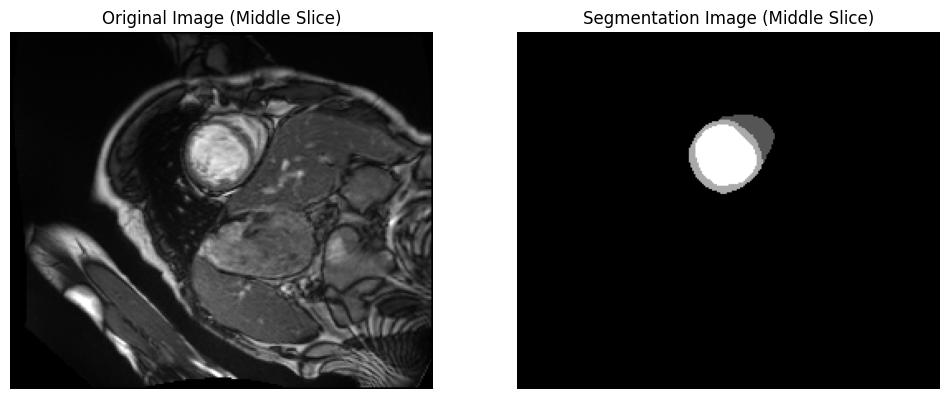

In [6]:
# Visualize the data in subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

slice_index = data.shape[2] // 2
slice_index = 5

axes[0].imshow(data[:, :, slice_index], cmap='gray')
axes[0].set_title('Original Image (Middle Slice)')
axes[0].axis('off')

axes[1].imshow(data_seg[:, :, slice_index], cmap='gray')
axes[1].set_title('Segmentation Image (Middle Slice)')
axes[1].axis('off')
plt.show()

Labels in the segmentation image: [0. 1. 2. 3.]


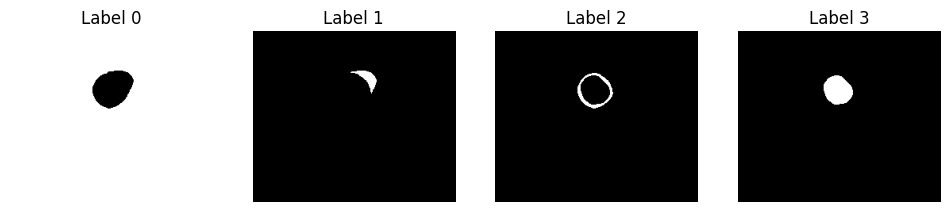

In [7]:
# Get all diferrent values in the segmentation image
unique_values = np.unique(data_seg)
print("Labels in the segmentation image:", unique_values)

# Visualize each segmentation labels individually in subplots
fig, axes = plt.subplots(1, len(unique_values), figsize=(12, 6))
for i, value in enumerate(unique_values):
    axes[i].imshow(data_seg[:, :, slice_index] == value, cmap='gray')
    axes[i].set_title(f'Label {int(value)}')
    axes[i].axis('off')
plt.show()

Labels: 
* '0' : Background
* '1' : Right Ventricule
* '2' : Miocardium
* '3' : Left Ventricule

**Understanding the partial segmentation given**

In [8]:
# Load the NIfTI file
img_test = nib.load('Dataset/Test/101/101_ED.nii')  
img_test_seg = nib.load('Dataset/Test/101/101_ED_seg.nii')
# Get the image data as a NumPy array
data_test = img_test.get_fdata()
data_test_seg = img_test_seg.get_fdata()

# Print shape
print("Shape:", data_test.shape)
print("Shape:", data_test_seg.shape)

Shape: (216, 256, 8)
Shape: (216, 256, 8)


In [9]:
# Get all diferrent values in the segmentation image
unique_values = np.unique(data_test_seg)
unique_values 

array([0., 1., 2.])

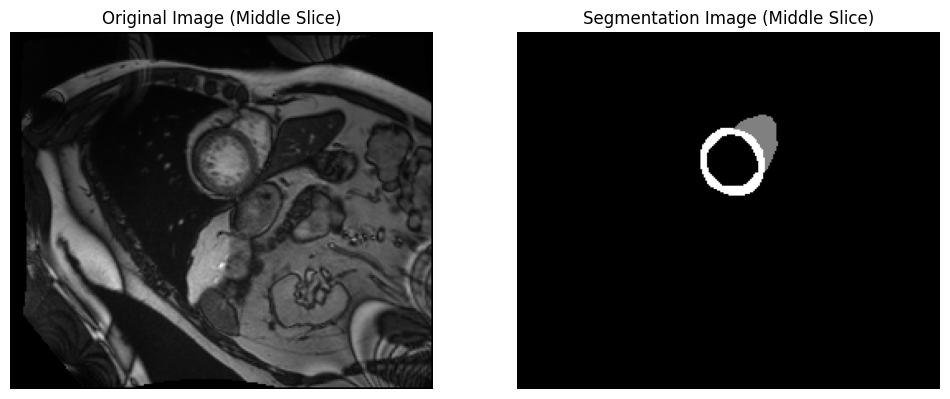

In [10]:
# Visualize the data_test in subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

slice_index = data_test.shape[2] // 2
slice_index = 5

axes[0].imshow(data_test[:, :, slice_index], cmap='gray')
axes[0].set_title('Original Image (Middle Slice)')
axes[0].axis('off')

axes[1].imshow(data_test_seg[:, :, slice_index], cmap='gray')
axes[1].set_title('Segmentation Image (Middle Slice)')
axes[1].axis('off')
plt.show()

**Simple implementation of the complete segmentation**

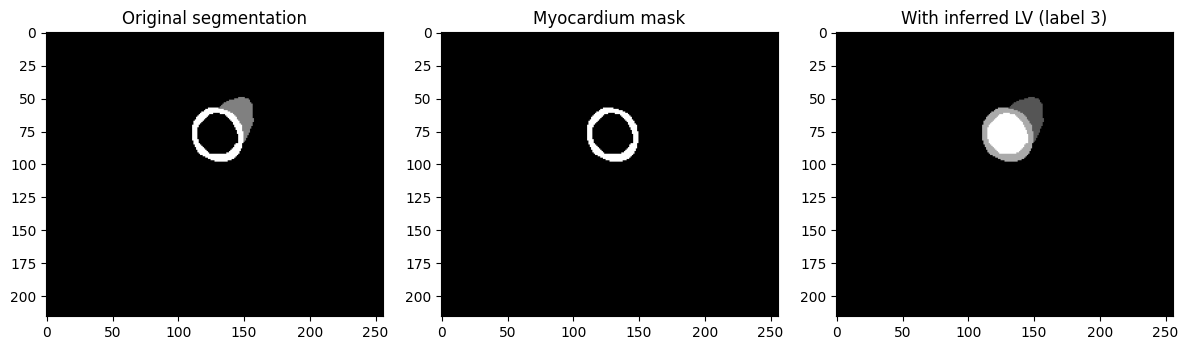

In [11]:
slice_seg = data_test_seg[:, :, slice_index]

myocardium_mask = (slice_seg == 2)

# Fill the "hole" inside the myocardium
filled = ndi.binary_fill_holes(myocardium_mask)

# LV cavity is the region inside the myocardium
lv_mask = filled & (~myocardium_mask)

# Assign label 3 to the LV cavity
slice_with_lv = np.copy(slice_seg)
slice_with_lv[lv_mask] = 3

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(slice_seg, cmap='gray')
axs[0].set_title('Original segmentation')

axs[1].imshow(myocardium_mask, cmap='gray')
axs[1].set_title('Myocardium mask')

axs[2].imshow(slice_with_lv, cmap='gray')
axs[2].set_title('With inferred LV (label 3)')

plt.tight_layout()
plt.show()

In [12]:
def lv_seg(slice_seg: np.ndarray, myocardium_label=2, lv_label=3) -> np.ndarray:
    """
    Infers the left ventricle (LV) cavity region from the myocardium in a single segmentation slice.

    Parameters:
        slice_seg (np.ndarray): 2D array with the segmentation slice.
        myocardium_label (int): Label corresponding to myocardium in the segmentation.
        lv_label (int): Label to assign to the inferred LV cavity.

    Returns:
        np.ndarray: A copy of the slice segmentation with the inferred LV cavity added.
    """
    myocardium_mask = (slice_seg == myocardium_label)

    # Fill the hole inside the myocardium
    filled = ndi.binary_fill_holes(myocardium_mask)

    # LV is the region inside the myocardium
    lv_mask = filled & (~myocardium_mask)

    # Create a copy and assign label to LV
    new_slice = np.copy(slice_seg)
    new_slice[lv_mask] = lv_label

    return new_slice

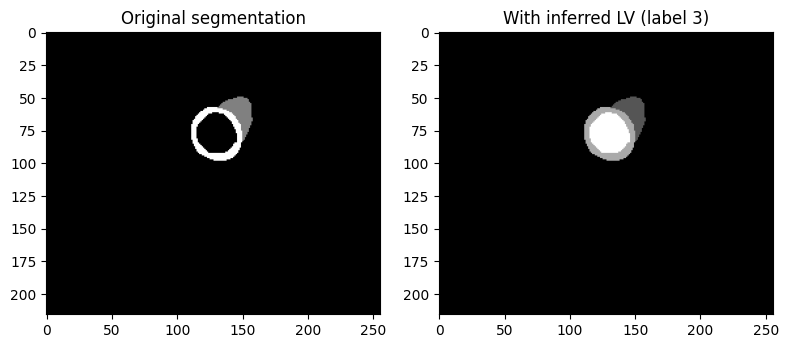

In [13]:
slice_index = 5
slice_seg = data_test_seg[:, :, slice_index]
slice_with_lv = lv_seg(slice_seg)

# plt.imshow(slice_seg, cmap='gray')
# plt.title('Original segmentation')
# plt.axis('off')
# plt.show()

# plt.imshow(slice_with_lv, cmap='gray')
# plt.title('With inferred LV (label 3)')
# plt.axis('off')
# plt.show()

fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].imshow(slice_seg, cmap='gray')
axs[0].set_title('Original segmentation')

axs[1].imshow(slice_with_lv, cmap='gray')
axs[1].set_title('With inferred LV (label 3)')

plt.tight_layout()
plt.show()


In [14]:
def lv_seg_volume(seg: np.ndarray, myocardium_label=2, lv_label=3) -> np.ndarray:
    """
    Infers the left ventricle (LV) cavity region from the myocardium across all slices of a 3D segmentation.

    Parameters:
        seg (np.ndarray): 3D segmentation array (height, width, num_slices)
        myocardium_label (int): Label for myocardium
        lv_label (int): Label to assign to the inferred LV cavity

    Returns:
        np.ndarray: A new 3D segmentation with LV cavity added.
    """
    new_seg = np.copy(seg)

    for z in range(seg.shape[2]):
        slice_seg = seg[:, :, z]
        myocardium_mask = (slice_seg == myocardium_label)
        filled = ndi.binary_fill_holes(myocardium_mask)
        lv_mask = filled & (~myocardium_mask)
        new_seg[:, :, z][lv_mask] = lv_label

    return new_seg


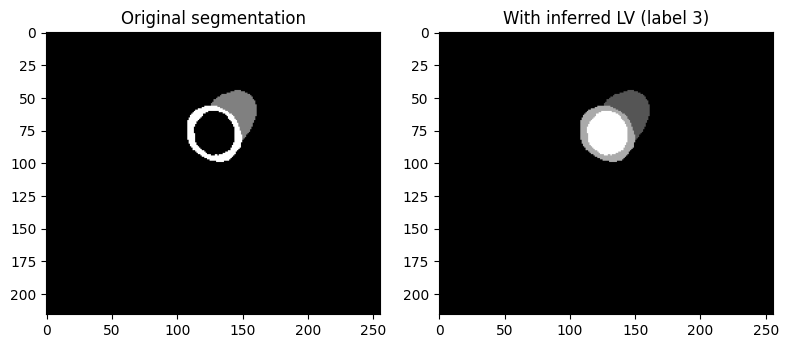

In [15]:
data_test_seg_with_lv = lv_seg_volume(data_test_seg)

slice_index = 4

fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].imshow(data_test_seg[:, :, slice_index], cmap='gray')
axs[0].set_title('Original segmentation')

axs[1].imshow(data_test_seg_with_lv[:, :, slice_index], cmap='gray')
axs[1].set_title('With inferred LV (label 3)')

plt.tight_layout()
plt.show()

### Feature Engineering

##### Features from *Densely Connected Fully Convolutional Network for Short-Axis Cardiac Cine MR Image Segmentation and Heart Diagnosis Using Random Forest*

* Ejection fraction of left ventricle and right ventricle

* Volume of the left ventricle at end systole and end diastoles phases

* Volume of the right ventricle at end systole and end diastole phases

* Mass of the myocardium at end diastole and its volume at end systole

* Patient height and weight

In [16]:
def compute_volume(seg, label):
    # Count voxels of the given label and multiply by voxel volume
    return np.sum(seg == label)

def compute_ef(seg_ed, seg_es, label):
    edv = compute_volume(seg_ed, label)
    esv = compute_volume(seg_es, label)
    ef = (edv - esv) / edv if edv > 0 else 0
    return ef

In [17]:
def compute_volume(seg, label, voxel_volume_mm3=1.0):
    """
    Computes the volume of a given label in the segmentation mask.

    Parameters:
        seg (np.ndarray): 3D segmentation array
        label (int): Label to extract
        voxel_volume_mm3 (float): Voxel volume in mm³ (default 1.0 = raw voxel count)

    Returns:
        float: Volume in mm³ (or mL if divided by 1000)
    """
    return np.sum(seg == label) * voxel_volume_mm3 / 1000  # → volume in mL

def compute_ef(seg_ed, seg_es, label, voxel_volume_mm3=1.0):
    edv = compute_volume(seg_ed, label, voxel_volume_mm3)
    esv = compute_volume(seg_es, label, voxel_volume_mm3)
    ef = (edv - esv) / edv if edv > 0 else 0
    return ef


In [18]:
# Load the NIfTI file
img_ed = nib.load('Dataset/Train/001/001_ED.nii')  
img_ed_seg = nib.load('Dataset/Train/001/001_ED_seg.nii')

img_es = nib.load('Dataset/Train/001/001_ES.nii')  
img_es_seg = nib.load('Dataset/Train/001/001_ES_seg.nii')

# Get the image data as a NumPy array
data_ed = img_ed.get_fdata()
data_ed_seg = img_ed_seg.get_fdata()

data_es = img_es.get_fdata()
data_es_seg = img_es_seg.get_fdata()

print("Features for data 001:\n")

# Calculate Ejection Fractions
ef_lv = compute_ef(data_ed_seg, data_es_seg, label=3)
ef_rv = compute_ef(data_ed_seg, data_es_seg, label=1)

## Print Ejection Fractions
print(f"EF of the LV: {ef_lv:.2f}")
print(f"EF of the RV: {ef_rv:.2f}")

# Calculate volumes of LV and RV at ED and ES
vol_lv_ed = compute_volume(data_ed_seg, label=3)
vol_lv_es = compute_volume(data_es_seg, label=3)

vol_rv_ed = compute_volume(data_ed_seg, label=1)
vol_rv_es = compute_volume(data_es_seg, label=1)

## Print volumes
print(f"Volume of LV at ED: {vol_lv_ed:.2f}")
print(f"Volume of LV at ES: {vol_lv_es:.2f}")
print(f"Volume of RV at ED: {vol_rv_ed:.2f}")
print(f"Volume of RV at ES: {vol_rv_es:.2f}")

# Calculate the "mass"(volume instead as we don't have density) of myocardium at ED and ES
vol_myocardium_ed = compute_volume(data_ed_seg, label=2)
vol_myocardium_es = compute_volume(data_es_seg, label=2)

## Print volumes
print(f"Volume of myocardium at ED: {vol_myocardium_ed:.2f}")
print(f"Volume of myocardium at ES: {vol_myocardium_es:.2f}")


Features for data 001:

EF of the LV: 0.24
EF of the RV: 0.57
Volume of LV at ED: 12.10
Volume of LV at ES: 9.24
Volume of RV at ED: 5.72
Volume of RV at ES: 2.44
Volume of myocardium at ED: 6.73
Volume of myocardium at ES: 7.99


In [19]:
def compute_bsa(height_cm, weight_kg):
    return np.sqrt((height_cm * weight_kg) / 3600)

Thickness values (in voxels):
Mean: 2.34
Max: 5.00
Min: 1.00
Std: 1.10


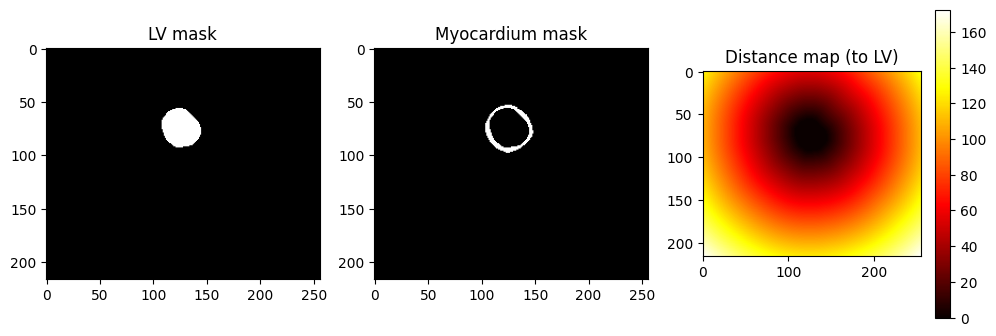

In [20]:
from scipy.ndimage import distance_transform_edt

# Let's say you already have a 3D segmentation loaded: seg_volume
slice_index = 5
slice_seg = data_seg[:, :, slice_index]  # 2D slice

# Step 1: Create masks
lv_mask = (slice_seg == 3)
myo_mask = (slice_seg == 2)

# Step 2: Distance from every pixel to nearest LV pixel
# We apply ~lv_mask to get where LV is NOT, which is where distance is measured
lv_distance = distance_transform_edt(~lv_mask)

# Step 3: Keep only the distances **inside myocardium**
myo_distances = lv_distance[myo_mask]

# Step 4: Compute statistics
print("Thickness values (in voxels):")
print(f"Mean: {np.mean(myo_distances):.2f}")
print(f"Max: {np.max(myo_distances):.2f}")
print(f"Min: {np.min(myo_distances):.2f}")
print(f"Std: {np.std(myo_distances):.2f}")

# Optional: visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("LV mask")
plt.imshow(lv_mask, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Myocardium mask")
plt.imshow(myo_mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Distance map (to LV)")
plt.imshow(lv_distance, cmap='hot')
plt.colorbar()
plt.show()


In [21]:
from scipy.ndimage import binary_dilation

def compute_thickness_from_contours(seg: np.ndarray, lv_label=3, myo_label=2, pixel_size_mm=1.0) -> dict:
    """
    Computes true myocardial thickness by measuring average distance between
    inner and outer contours of the myocardium in each slice.

    Parameters:
        seg (np.ndarray): 3D segmentation volume
        lv_label (int): Label for left ventricle cavity
        myo_label (int): Label for myocardium
        pixel_size_mm (float): Size of each pixel in mm (default 1.0)

    Returns:
        dict: mean, std, min, max thickness (in pixels)
    """
    thickness_per_slice = []

    for z in range(seg.shape[2]):
        slice_seg = seg[:, :, z]

        # Masks
        lv_mask = (slice_seg == lv_label)
        myo_mask = (slice_seg == myo_label)

        lv_dilated = binary_dilation(lv_mask)
        inner_border = myo_mask & lv_dilated

        # Get outer myocardium border: myocardium pixels that touch background
        bg_mask = (slice_seg == 0)
        bg_dilated = binary_dilation(bg_mask)
        outer_border = myo_mask & bg_dilated

        if np.sum(myo_mask) == 0 or np.sum(lv_mask) == 0:
            continue  # skip empty slices
        
        inner_contours = find_contours(inner_border.astype(float), level=0.5)
        outer_contours = find_contours(outer_border.astype(float), level=0.5)

        if not inner_contours or not outer_contours:
            continue  # skip if no contours found

        # We'll take the largest contour from each set (some slices may have holes)
        inner_pts = np.concatenate(inner_contours)
        outer_pts = np.concatenate(outer_contours)

        # Compute distances between all contour points
        dists = cdist(inner_pts, outer_pts)
        min_dists = np.min(dists, axis=1)  # closest outer point to each inner point

        # Average thickness for this slice
        thickness_per_slice.append(np.mean(min_dists)*pixel_size_mm)

    # Final stats
    if len(thickness_per_slice) == 0:
        return {
            'thickness_mean': 0,
            'thickness_std': 0,
            'thickness_min': 0,
            'thickness_max': 0
        }

    return {
        'thickness_mean': np.mean(thickness_per_slice),
        'thickness_std': np.std(thickness_per_slice),
        'thickness_min': np.min(thickness_per_slice),
        'thickness_max': np.max(thickness_per_slice)
    }


In [22]:
from scipy.ndimage import distance_transform_edt

### other method

def compute_thickness_from_lv_distance(seg: np.ndarray, lv_label=3, myo_label=2, pixel_size_mm=1.0) -> dict:
    """
    Approximates myocardium thickness by measuring the average distance from
    myocardium pixels to the LV cavity (inner wall), per slice.

    Parameters:
        seg (np.ndarray): 3D segmentation volume
        lv_label (int): Label for LV cavity
        myo_label (int): Label for myocardium

    Returns:
        dict: mean, std, min, max thickness (in voxels)
    """
    thickness_per_slice = []

    for z in range(seg.shape[2]):
        slice_seg = seg[:, :, z]

        lv_mask = (slice_seg == lv_label)
        myo_mask = (slice_seg == myo_label)

        if np.sum(myo_mask) == 0 or np.sum(lv_mask) == 0:
            continue

        # Distance from every pixel to the nearest LV pixel
        dist_map = distance_transform_edt(~lv_mask)

        # Keep only values inside myocardium
        myo_distances = dist_map[myo_mask]

        # Mean thickness for this slice
        slice_thickness = np.mean(myo_distances) * pixel_size_mm
        thickness_per_slice.append(slice_thickness)

    if len(thickness_per_slice) == 0:
        return {
            'thickness_mean': 0,
            'thickness_std': 0,
            'thickness_min': 0,
            'thickness_max': 0
        }

    return {
        'thickness_mean': np.mean(thickness_per_slice),
        'thickness_std': np.std(thickness_per_slice),
        'thickness_min': np.min(thickness_per_slice),
        'thickness_max': np.max(thickness_per_slice)
    }


In [23]:
def compute_apical_rvc_lvc_ratio(seg: np.ndarray, lv_label=3, rv_label=1, myo_label=2, epsilon=1e-6):
    """
    Computes the RVC to LVC pixel area ratio at the apical slice (lowest slice with visible myocardium).

    Parameters:
        seg (np.ndarray): 3D segmentation volume
        lv_label (int): Label for LVC
        rv_label (int): Label for RVC
        myo_label (int): Label for myocardium

    Returns:
        float: RVC / LVC ratio at apical slice
    """
    apical_index = None

    # Search from base to apex (low to high z)
    for z in range(seg.shape[2] - 1, -1, -1):
        slice_seg = seg[:, :, z]
        if np.sum(slice_seg == myo_label) > 0:
            apical_index = z
            break

    if apical_index is None:
        return 0.0  # no myocardium found

    # Get LVC and RVC areas in the apical slice
    apical_slice = seg[:, :, apical_index]
    area_lvc = np.sum(apical_slice == lv_label)
    area_rvc = np.sum(apical_slice == rv_label)

    return area_rvc / (area_lvc + epsilon)


In [24]:
def compute_volume_ratio(seg_ed, seg_es, label1, label2):
    """
    Computes the volume ratio of two labels in the segmentation mask.

    Parameters:
        seg (np.ndarray): 3D segmentation array
        label1 (int): First label
        label2 (int): Second label

    Returns:
        float: Volume ratio of label1 to label2
    """
    vol1 = min(compute_volume(seg_ed, label1), compute_volume(seg_es, label1))
    vol2 = min(compute_volume(seg_ed, label2), compute_volume(seg_es, label2))
    return vol1 / vol2 if vol2 > 0 else 0

In [25]:
print("Aditional Features for data 001:\n")

# Calculate the volume ratios
ratio_lv_rv = compute_volume_ratio(data_ed_seg, data_es_seg, label1=3, label2=1)
ratio_lv_myocardium = compute_volume_ratio(data_ed_seg, data_es_seg, label1=3, label2=2)
ratio_rv_myocardium = compute_volume_ratio(data_ed_seg, data_es_seg, label1=1, label2=2)

print(f"Volume ratio LV/RV: {ratio_lv_rv:.2f}")
print(f"Volume ratio LV/myocardium: {ratio_lv_myocardium:.2f}")
print(f"Volume ratio RV/myocardium: {ratio_rv_myocardium:.2f}")

# Volumes divided by BSA
height_cm = 184
weight_kg = 95
bsa = compute_bsa(height_cm, weight_kg)

vol_lv_ed_bsa = vol_lv_ed / bsa
vol_lv_es_bsa = vol_lv_es / bsa
vol_rv_ed_bsa = vol_rv_ed / bsa
vol_rv_es_bsa = vol_rv_es / bsa
vol_myocardium_ed_bsa = vol_myocardium_ed / bsa
vol_myocardium_es_bsa = vol_myocardium_es / bsa

print(f"Volume of LV at ED/BSA: {vol_lv_ed_bsa:.2f}")
print(f"Volume of LV at ES/BSA: {vol_lv_es_bsa:.2f}")
print(f"Volume of RV at ED/BSA: {vol_rv_ed_bsa:.2f}")
print(f"Volume of RV at ES/BSA: {vol_rv_es_bsa:.2f}")
print(f"Volume of myocardium at ED/BSA: {vol_myocardium_ed_bsa:.2f}")
print(f"Volume of myocardium at ES/BSA: {vol_myocardium_es_bsa:.2f}")

# Calculate the thickness of the myocardium
thickness = compute_thickness_from_contours(data_ed_seg)

print(f"Mean thickness: {thickness['thickness_mean']:.2f}")
print(f"Std thickness: {thickness['thickness_std']:.2f}")
print(f"Min thickness: {thickness['thickness_min']:.2f}")
print(f"Max thickness: {thickness['thickness_max']:.2f}")

# Calculate apical RVC/LVC ratio
apical_ratio = compute_apical_rvc_lvc_ratio(data_ed_seg, lv_label=3, rv_label=1, myo_label=2)
print(f"Apical RVC/LVC ratio: {apical_ratio:.2f}")

Aditional Features for data 001:

Volume ratio LV/RV: 3.79
Volume ratio LV/myocardium: 1.37
Volume ratio RV/myocardium: 0.36
Volume of LV at ED/BSA: 5.49
Volume of LV at ES/BSA: 4.19
Volume of RV at ED/BSA: 2.60
Volume of RV at ES/BSA: 1.11
Volume of myocardium at ED/BSA: 3.05
Volume of myocardium at ES/BSA: 3.63
Mean thickness: 5.44
Std thickness: 1.62
Min thickness: 2.31
Max thickness: 7.36
Apical RVC/LVC ratio: 0.13


In [26]:
def compute_apical_rvc_lvc_ratio(seg: np.ndarray, lv_label=3, rv_label=1, myo_label=2, epsilon=1e-6, debug=False):
    """
    Computes the RVC to LVC pixel area ratio at the apical slice (last slice with myocardium).

    Parameters:
        seg (np.ndarray): 3D segmentation array
        lv_label (int): Label for LV cavity
        rv_label (int): Label for RV cavity
        myo_label (int): Label for myocardium
        epsilon (float): Small value to prevent division by zero
        debug (bool): If True, print debugging info

    Returns:
        float: RVC / LVC area ratio at apical slice
    """
    apical_index = None

    # Search from apex up (high z to low z)
    for z in range(seg.shape[2] - 1, -1, -1):
        slice_seg = seg[:, :, z]
        if np.any(slice_seg == myo_label):
            apical_index = z
            break

    if apical_index is None:
        if debug:
            print("❌ No myocardium found in any slice.")
        return 0.0

    apical_slice = seg[:, :, apical_index]
    area_lvc = np.sum(apical_slice == lv_label)
    area_rvc = np.sum(apical_slice == rv_label)

    if debug:
        print(f"✅ Apical slice index: {apical_index}")
        print(f"   LVC area: {area_lvc}")
        print(f"   RVC area: {area_rvc}")

    if area_lvc == 0 and area_rvc == 0:
        if debug:
            print("⚠️ No LVC or RVC in apical slice.")
        return 0.0

    return area_rvc / (area_lvc + epsilon)


In [27]:
img_ed_seg_2 = nib.load('Dataset/Train/003/003_ED_seg.nii')

# Get the image data as a NumPy array
data_ed_seg_2 = img_ed_seg_2.get_fdata()

compute_apical_rvc_lvc_ratio(data_ed_seg_2, lv_label=3, rv_label=1, myo_label=2, debug=True)

✅ Apical slice index: 9
   LVC area: 130
   RVC area: 0


0.0

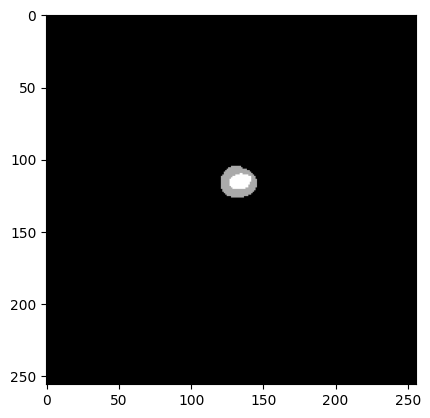

In [28]:
plt.imshow(data_ed_seg_2[:, :, 9], cmap='gray')

In [29]:
dataset = meta_data_train.copy()

# Add new columns for designed features
dataset['Ejection Fraction (LV)'] = 0.0
dataset['Ejection Fraction (RV)'] = 0.0
dataset['Volume (LV) ED'] = 0.0
dataset['Volume (LV) ES'] = 0.0
dataset['Volume (RV) ED'] = 0.0
dataset['Volume (RV) ES'] = 0.0
dataset['Volume (Myocardium) ED'] = 0.0
dataset['Volume (Myocardium) ES'] = 0.0

# From the other paper

dataset['Volume Ratio (LV/RV)'] = 0.0
dataset['Volume Ratio (LV/Myocardium)'] = 0.0
dataset['Volume Ratio (RV/Myocardium)'] = 0.0

dataset['Volume (LV) ED / BSA'] = 0.0
dataset['Volume (LV) ES / BSA'] = 0.0
dataset['Volume (RV) ED / BSA'] = 0.0
dataset['Volume (RV) ES / BSA'] = 0.0
dataset['Volume (Myocardium) ED / BSA'] = 0.0
dataset['Volume (Myocardium) ES / BSA'] = 0.0

dataset['Myocardium Thickness Mean'] = 0.0
dataset['Myocardium Thickness Std'] = 0.0
dataset['Myocardium Thickness Min'] = 0.0
dataset['Myocardium Thickness Max'] = 0.0

dataset['Apical RVC/LVC Ratio'] = 0.0

# Drop ID column
dataset.drop(columns=['Id'], inplace=True)

dataset.head()

,Category,Height,Weight,Ejection Fraction (LV),Ejection Fraction (RV),Volume (LV) ED,Volume (LV) ES,Volume (RV) ED,Volume (RV) ES,Volume (Myocardium) ED,...,Volume (LV) ES / BSA,Volume (RV) ED / BSA,Volume (RV) ES / BSA,Volume (Myocardium) ED / BSA,Volume (Myocardium) ES / BSA,Myocardium Thickness Mean,Myocardium Thickness Std,Myocardium Thickness Min,Myocardium Thickness Max,Apical RVC/LVC Ratio
0,2,184.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,160.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,165.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,159.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,165.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Define base path
base_path = 'Dataset/Train/'

# Loop through each subject
for idx in tqdm(range(100)):
    subject_id = f"{idx+1:03d}"  # format: '001', '002', ...
    subject_path = os.path.join(base_path, subject_id)

    # Load images and segmentations
    seg_ed = nib.load(os.path.join(subject_path, f"{subject_id}_ED_seg.nii")).get_fdata()
    seg_es = nib.load(os.path.join(subject_path, f"{subject_id}_ES_seg.nii")).get_fdata()

    # Load header for voxel size
    header = nib.load(os.path.join(subject_path, f"{subject_id}_ED_seg.nii")).header
    voxel_volume = np.prod(header.get_zooms())  # mm³
    pixel_size_mm = np.mean(header.get_zooms()[:2])  # mm

    # Get height and weight from dataset
    height_cm = dataset.at[idx, 'Height']
    weight_kg = dataset.at[idx, 'Weight']
    bsa = compute_bsa(height_cm, weight_kg)

    # Compute features
    ef_lv = compute_ef(seg_ed, seg_es, label=3, voxel_volume_mm3=voxel_volume)
    ef_rv = compute_ef(seg_ed, seg_es, label=1, voxel_volume_mm3=voxel_volume)

    vol_lv_ed = compute_volume(seg_ed, 3, voxel_volume)
    vol_lv_es = compute_volume(seg_es, 3, voxel_volume)
    vol_rv_ed = compute_volume(seg_ed, 1, voxel_volume)
    vol_rv_es = compute_volume(seg_es, 1, voxel_volume)
    vol_myo_ed = compute_volume(seg_ed, 2, voxel_volume)
    vol_myo_es = compute_volume(seg_es, 2, voxel_volume)

    vol_lv_ed_bsa = vol_lv_ed / bsa
    vol_lv_es_bsa = vol_lv_es / bsa
    vol_rv_ed_bsa = vol_rv_ed / bsa
    vol_rv_es_bsa = vol_rv_es / bsa
    vol_myo_ed_bsa = vol_myo_ed / bsa
    vol_myo_es_bsa = vol_myo_es / bsa

    ratio_lv_rv = compute_volume_ratio(seg_ed, seg_es, label1=3, label2=1)
    ratio_lv_myocardium = compute_volume_ratio(seg_ed, seg_es, label1=3, label2=2)
    ratio_rv_myocardium = compute_volume_ratio(seg_ed, seg_es, label1=1, label2=2)

    thickness = compute_thickness_from_lv_distance(seg_ed, pixel_size_mm=pixel_size_mm)
    thickness_mean = thickness['thickness_mean']
    thickness_std = thickness['thickness_std']
    thickness_min = thickness['thickness_min']
    thickness_max = thickness['thickness_max']

    apical_ratio = compute_apical_rvc_lvc_ratio(seg_ed, lv_label=3, rv_label=1, myo_label=2)

    # Fill in the dataset
    dataset.at[idx, 'Ejection Fraction (LV)'] = ef_lv
    dataset.at[idx, 'Ejection Fraction (RV)'] = ef_rv

    dataset.at[idx, 'Volume (LV) ED'] = vol_lv_ed
    dataset.at[idx, 'Volume (LV) ES'] = vol_lv_es
    dataset.at[idx, 'Volume (RV) ED'] = vol_rv_ed
    dataset.at[idx, 'Volume (RV) ES'] = vol_rv_es
    dataset.at[idx, 'Volume (Myocardium) ED'] = vol_myo_ed
    dataset.at[idx, 'Volume (Myocardium) ES'] = vol_myo_es

    dataset.at[idx, 'Volume Ratio (LV/RV)'] = ratio_lv_rv
    dataset.at[idx, 'Volume Ratio (LV/Myocardium)'] = ratio_lv_myocardium
    dataset.at[idx, 'Volume Ratio (RV/Myocardium)'] = ratio_rv_myocardium

    dataset.at[idx, 'Volume (LV) ED / BSA'] = vol_lv_ed_bsa
    dataset.at[idx, 'Volume (LV) ES / BSA'] = vol_lv_es_bsa
    dataset.at[idx, 'Volume (RV) ED / BSA'] = vol_rv_ed_bsa
    dataset.at[idx, 'Volume (RV) ES / BSA'] = vol_rv_es_bsa
    dataset.at[idx, 'Volume (Myocardium) ED / BSA'] = vol_myo_ed_bsa
    dataset.at[idx, 'Volume (Myocardium) ES / BSA'] = vol_myo_es_bsa

    dataset.at[idx, 'Myocardium Thickness Mean'] = thickness_mean
    dataset.at[idx, 'Myocardium Thickness Std'] = thickness_std
    dataset.at[idx, 'Myocardium Thickness Min'] = thickness_min
    dataset.at[idx, 'Myocardium Thickness Max'] = thickness_max


    dataset.at[idx, 'Apical RVC/LVC Ratio'] = apical_ratio


100%|██████████| 100/100 [00:05<00:00, 19.75it/s]


In [31]:
dataset.head()

,Category,Height,Weight,Ejection Fraction (LV),Ejection Fraction (RV),Volume (LV) ED,Volume (LV) ES,Volume (RV) ED,Volume (RV) ES,Volume (Myocardium) ED,...,Volume (LV) ES / BSA,Volume (RV) ED / BSA,Volume (RV) ES / BSA,Volume (Myocardium) ED / BSA,Volume (Myocardium) ES / BSA,Myocardium Thickness Mean,Myocardium Thickness Std,Myocardium Thickness Min,Myocardium Thickness Max,Apical RVC/LVC Ratio
0,2,184.0,95.0,0.236533,0.573825,295.507812,225.610352,139.721680,59.545898,164.257812,...,102.385760,63.408041,27.022927,74.542949,88.525292,4.767523,0.454397,3.726774,5.158545,0.126697
1,2,160.0,70.0,0.291412,0.694774,265.744400,188.303375,94.432068,28.823090,160.433578,...,106.757979,53.537950,16.341156,90.957289,109.174181,4.740556,0.555498,3.528683,5.461565,0.000000
2,2,165.0,77.0,0.128728,0.092282,276.708984,241.088867,192.333984,174.584961,191.845703,...,128.333805,102.381136,92.933169,102.121219,107.033643,5.446944,0.239279,5.097765,5.930602,0.000000
3,2,159.0,46.0,0.131781,0.204398,260.847092,226.472473,106.264114,84.543991,168.452454,...,158.887304,74.552189,59.313905,118.181940,122.745556,4.787894,0.623877,3.305861,5.395840,0.000000
4,2,165.0,77.0,0.229378,0.562645,290.797119,224.094727,170.463867,74.553223,201.392578,...,119.287669,90.739473,39.685361,107.203108,123.635164,5.280548,0.646907,3.674966,6.060458,0.407563


In [32]:
dataset.describe()

,Category,Height,Weight,Ejection Fraction (LV),Ejection Fraction (RV),Volume (LV) ED,Volume (LV) ES,Volume (RV) ED,Volume (RV) ES,Volume (Myocardium) ED,...,Volume (LV) ES / BSA,Volume (RV) ED / BSA,Volume (RV) ES / BSA,Volume (Myocardium) ED / BSA,Volume (Myocardium) ES / BSA,Myocardium Thickness Mean,Myocardium Thickness Std,Myocardium Thickness Min,Myocardium Thickness Max,Apical RVC/LVC Ratio
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.000000,170.840000,74.960000,0.463846,0.467321,164.614193,99.056428,152.986584,85.884560,123.775221,...,53.232581,81.980966,46.263835,66.021282,74.732811,4.973305,0.688931,3.895319,6.005057,1.215823
std,1.421338,9.710683,16.632037,0.199215,0.178873,74.272020,78.756958,55.152814,52.466856,48.578662,...,43.279443,29.499348,28.599660,25.776505,28.006025,1.115565,0.386367,0.854620,1.558749,2.659737
min,0.000000,140.000000,35.000000,0.104767,0.019169,49.267578,19.364365,47.365570,10.319305,32.645727,...,10.055172,25.612367,6.879537,24.482285,25.807255,3.004529,0.186486,2.390499,3.627713,0.000000
25%,1.000000,165.000000,62.750000,0.279756,0.381631,118.056015,41.768805,111.767578,51.590940,92.222350,...,22.654641,61.865425,25.818548,47.404503,53.227966,4.379575,0.410341,3.375475,5.071411,0.000000
50%,2.000000,171.500000,75.000000,0.536520,0.484081,149.010534,64.111283,152.006927,70.083984,117.755895,...,35.449407,75.521332,37.568092,63.114447,71.582507,4.710732,0.583769,3.722765,5.610265,0.000000
75%,3.000000,178.000000,85.000000,0.622391,0.600360,199.784669,132.576656,181.683391,108.201879,156.850769,...,68.987794,99.267540,60.123285,77.015800,88.557338,5.217546,0.866436,4.176637,6.387929,1.120044
max,4.000000,192.000000,123.000000,0.818679,0.859419,374.376417,334.457137,295.117188,262.817383,259.052658,...,207.621243,156.905692,138.577631,142.483909,153.537213,8.547919,2.009972,6.667188,10.547352,15.078947


### Classification Methods

**Preparing the data**

In [33]:
# Dataset to numpy array
dataset_np = dataset.to_numpy()

# Shuffle
order = np.arange(dataset_np.shape[0])
np.random.shuffle(order)
dataset_np_shuffled = dataset_np[order]

X = dataset_np_shuffled[:, 1:]  # Features
y = dataset_np_shuffled[:, 0]  # Labels

def print_class_dist(y, name):
    counts = Counter(y)
    print(f"{name} distribution:")
    for cls in sorted(counts):
        print(f"  Class {cls}: {counts[cls]} samples")
    print()

print_class_dist(y, "Full")

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)

print_class_dist(y_train, "Train")
print_class_dist(y_test, "Test")

Full distribution:
  Class 0.0: 20 samples
  Class 1.0: 20 samples
  Class 2.0: 20 samples
  Class 3.0: 20 samples
  Class 4.0: 20 samples

Train distribution:
  Class 0.0: 16 samples
  Class 1.0: 16 samples
  Class 2.0: 16 samples
  Class 3.0: 16 samples
  Class 4.0: 16 samples

Test distribution:
  Class 0.0: 4 samples
  Class 1.0: 4 samples
  Class 2.0: 4 samples
  Class 3.0: 4 samples
  Class 4.0: 4 samples



In [34]:
# Normalizing minmax and standardization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


normalizer = MinMaxScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

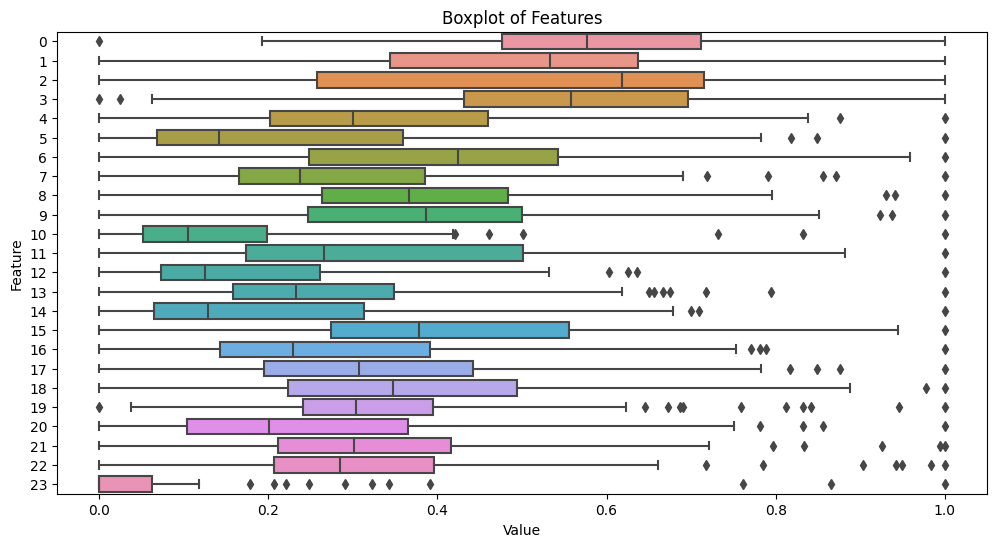

In [35]:
# Boxplot of the features

plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train, orient="h")
plt.title("Boxplot of Features")
plt.xlabel("Value")
plt.ylabel("Feature")
plt.show()

**Logistic Regression**

In [36]:

logreg = LogisticRegression(
    multi_class='multinomial',   # good for softmax-style multiclass
    solver='lbfgs',              # robust optimizer for small/medium datasets
    max_iter=1000,               # allow enough iterations to converge
    random_state=42
)

# Optional: Tune regularization strength
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]  # smaller = stronger regularization
    }

grid_search = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_logreg = grid_search.best_estimator_

y_pred = best_logreg.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Cross Validation Score:")
print(grid_search.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         4
         2.0       1.00      1.00      1.00         4
         3.0       1.00      1.00      1.00         4
         4.0       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Confusion Matrix:
[[4 0 0 0 0]
 [0 4 0 0 0]
 [0 0 4 0 0]
 [0 0 0 4 0]
 [0 0 0 0 4]]
Cross Validation Score:
0.925


In [37]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(logreg, param_grid, cv=skf, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_logreg = grid_search.best_estimator_

y_pred = best_logreg.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Cross Validation Score:")
print(grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         4
         1.0       1.00      0.75      0.86         4
         2.0       1.00      1.00      1.00         4
         3.0       1.00      1.00      1.00         4
         4.0       1.00      0.75      0.86         4

    accuracy                           0.90        20
   macro avg       0.93      0.90      0.90        20
weighted avg       0.93      0.90      0.90        20

Confusion Matrix:
[[4 0 0 0 0]
 [1 3 0 0 0]
 [0 0 4 0 0]
 [0 0 0 4 0]
 [1 0 0 0 3]]
Cross Validation Score:
0.925


**KNN**

In [38]:
# KNN Classifier with cross-validation

knn = KNeighborsClassifier(n_neighbors=5)  # 5 neighbors is a common choice

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],  # odd numbers to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, n_jobs=-1, verbose=1)
grid_search_knn.fit(X_train_scaled, y_train)
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("KNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))
print("Best KNN Parameters:")
print(grid_search_knn.best_params_)
print("Croos Validation Score:")
print(grid_search_knn.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89         4
         1.0       1.00      1.00      1.00         4
         2.0       1.00      1.00      1.00         4
         3.0       1.00      1.00      1.00         4
         4.0       1.00      0.75      0.86         4

    accuracy                           0.95        20
   macro avg       0.96      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20

KNN Confusion Matrix:
[[4 0 0 0 0]
 [0 4 0 0 0]
 [0 0 4 0 0]
 [0 0 0 4 0]
 [1 0 0 0 3]]
Best KNN Parameters:
{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Croos Validation Score:
0.9125


**SVM**

In [39]:
# Support Vector Classifier (SVC) with cross-validation

svc = SVC(random_state=42)
param_grid_svc = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, n_jobs=-1, verbose=1)
grid_search_svc.fit(X_train_scaled, y_train)
best_svc = grid_search_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test_scaled)
print("SVC Classification Report:")
print(classification_report(y_test, y_pred_svc))
print("SVC Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svc))
print("Best SVC Parameters:")
print(grid_search_svc.best_params_)
print("Cross Validation Score:")
print(grid_search_svc.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVC Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89         4
         1.0       1.00      1.00      1.00         4
         2.0       1.00      1.00      1.00         4
         3.0       1.00      1.00      1.00         4
         4.0       1.00      0.75      0.86         4

    accuracy                           0.95        20
   macro avg       0.96      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20

SVC Confusion Matrix:
[[4 0 0 0 0]
 [0 4 0 0 0]
 [0 0 4 0 0]
 [0 0 0 4 0]
 [1 0 0 0 3]]
Best SVC Parameters:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Cross Validation Score:
0.95


**XGBoost**

In [40]:
# XGBoost Classifier with cross-validation

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("Best XGBoost Parameters:")
print(grid_search_xgb.best_params_)
print("Cross Validation Score:")
print(grid_search_xgb.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\pdalm\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\pdalm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pdalm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_

XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89         4
         1.0       1.00      1.00      1.00         4
         2.0       1.00      1.00      1.00         4
         3.0       1.00      1.00      1.00         4
         4.0       1.00      0.75      0.86         4

    accuracy                           0.95        20
   macro avg       0.96      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20

XGBoost Confusion Matrix:
[[4 0 0 0 0]
 [0 4 0 0 0]
 [0 0 4 0 0]
 [0 0 0 4 0]
 [1 0 0 0 3]]
Best XGBoost Parameters:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Cross Validation Score:
0.9125


**Random Forest**

In [41]:
# Random Forest Classifier with cross-validation

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [5, 10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
# Print classification report
print(classification_report(y_test, y_pred))
# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("Best Random Forest Parameters:")
print(grid_search.best_params_)
print("Cross Validation Score:")
print(grid_search.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89         4
         1.0       1.00      1.00      1.00         4
         2.0       1.00      1.00      1.00         4
         3.0       1.00      1.00      1.00         4
         4.0       1.00      0.75      0.86         4

    accuracy                           0.95        20
   macro avg       0.96      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20

Confusion Matrix:
[[4 0 0 0 0]
 [0 4 0 0 0]
 [0 0 4 0 0]
 [0 0 0 4 0]
 [1 0 0 0 3]]
Best Random Forest Parameters:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
Cross Validation Score:
0.95



Top Features:
                         Feature  Importance
2         Ejection Fraction (LV)    0.130558
11  Volume Ratio (LV/Myocardium)    0.121973
12  Volume Ratio (RV/Myocardium)    0.107503
9         Volume (Myocardium) ES    0.089616
22      Myocardium Thickness Max    0.082512
14          Volume (LV) ES / BSA    0.069510
4                 Volume (LV) ED    0.062781
10          Volume Ratio (LV/RV)    0.058967
7                 Volume (RV) ES    0.047520
13          Volume (LV) ED / BSA    0.045880


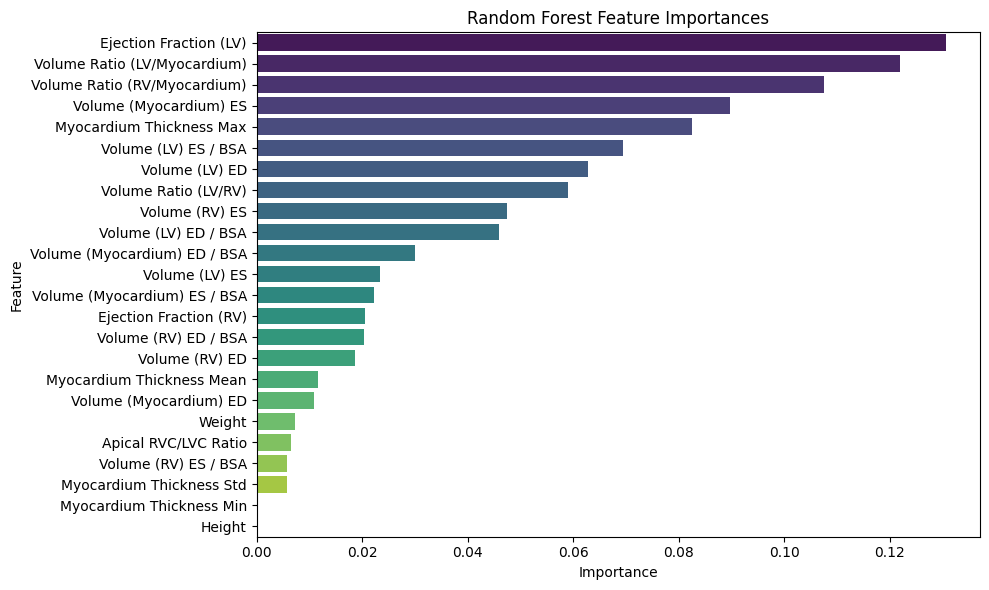

In [42]:
# Get importances from the best model
importances = best_rf.feature_importances_

# Make a nice DataFrame
feature_names = dataset.columns[1:]  # if X_train is a DataFrame
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print top N
print("\nTop Features:")
print(feat_importance_df.head(10))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


In [43]:
dataset_selected_features = dataset.copy()
columns_to_drop = [
    'Volume (LV) ED',
    'Volume (LV) ES',
    'Volume (RV) ED',
    'Volume (RV) ES',
    'Volume (Myocardium) ED',
    'Volume (Myocardium) ES', 
    'Apical RVC/LVC Ratio', 
    'Height',
    'Weight',
]

dataset_selected_features.drop(columns=columns_to_drop, inplace=True)

dataset_selected_features.head()

,Category,Ejection Fraction (LV),Ejection Fraction (RV),Volume Ratio (LV/RV),Volume Ratio (LV/Myocardium),Volume Ratio (RV/Myocardium),Volume (LV) ED / BSA,Volume (LV) ES / BSA,Volume (RV) ED / BSA,Volume (RV) ES / BSA,Volume (Myocardium) ED / BSA,Volume (Myocardium) ES / BSA,Myocardium Thickness Mean,Myocardium Thickness Std,Myocardium Thickness Min,Myocardium Thickness Max
0,2,0.236533,0.573825,3.788848,1.373514,0.362515,134.106400,102.385760,63.408041,27.022927,74.542949,88.525292,4.767523,0.454397,3.726774,5.158545
1,2,0.291412,0.694774,6.533074,1.173715,0.179657,150.662913,106.757979,53.537950,16.341156,90.957289,109.174181,4.740556,0.555498,3.528683,5.461565
2,2,0.128728,0.092282,1.380926,1.256681,0.910028,147.294719,128.333805,102.381136,92.933169,102.121219,107.033643,5.446944,0.239279,5.097765,5.930602
3,2,0.131781,0.204398,2.678753,1.344430,0.501886,183.003658,158.887304,74.552189,59.313905,118.181940,122.745556,4.787894,0.623877,3.305861,5.395840
4,2,0.229378,0.562645,3.005836,1.112726,0.370189,154.793962,119.287669,90.739473,39.685361,107.203108,123.635164,5.280548,0.646907,3.674966,6.060458


Fitting 3 folds for each of 144 candidates, totalling 432 fits
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89         4
         1.0       0.80      1.00      0.89         4
         2.0       1.00      0.75      0.86         4
         3.0       1.00      0.75      0.86         4
         4.0       1.00      1.00      1.00         4

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20

Confusion Matrix:
[[4 0 0 0 0]
 [0 4 0 0 0]
 [0 1 3 0 0]
 [1 0 0 3 0]
 [0 0 0 0 4]]
Cross Validation Score:
0.9126305792972461

Top Features:
                         Feature  Importance
3   Volume Ratio (LV/Myocardium)    0.121939
2           Volume Ratio (LV/RV)    0.113713
6           Volume (LV) ES / BSA    0.100983
0         Ejection Fraction (LV)    0.096833
4   Volume Ratio (RV/Myocardium)    0.092758
8           Volume (RV) ES / BSA    

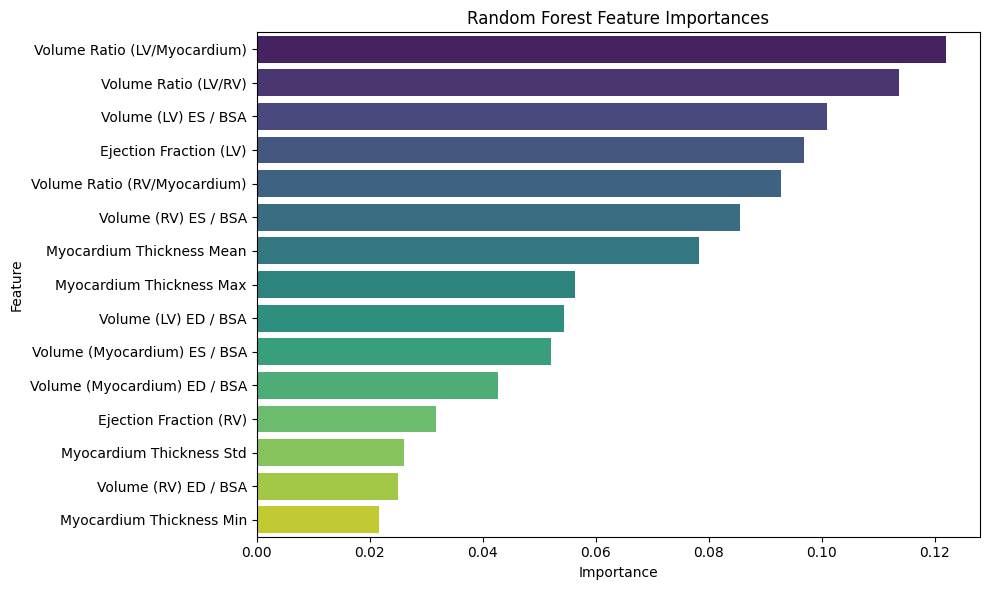

In [44]:
# To numpy array
dataset_selected_features_np = dataset_selected_features.to_numpy()

# Shuffle
order = np.arange(dataset_selected_features_np.shape[0])
np.random.shuffle(order)
dataset_selected_features_np_shuffled = dataset_selected_features_np[order]

X_sf = dataset_selected_features_np_shuffled[:, 1:]  # Features
y_sf = dataset_selected_features_np_shuffled[:, 0]  # Labels

# Split the dataset into training and test sets
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(X_sf, y_sf, test_size=0.2, stratify=y_sf, random_state=43)

# Normalizing minmax and standardization
scaler = StandardScaler()
X_train_sf_scaled = scaler.fit_transform(X_train_sf)
X_test_sf_scaled = scaler.transform(X_test_sf)
normalizer = MinMaxScaler()
X_train_sf = normalizer.fit_transform(X_train_sf)
X_test_sf = normalizer.transform(X_test_sf)

# Random Forest Classifier with cross-validation
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [5, 10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_sf, y_train_sf)
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_sf, y_train_sf)
y_pred = best_rf.predict(X_test_sf)
# Print classification report
print(classification_report(y_test_sf, y_pred))
# Print confusion matrix
cm = confusion_matrix(y_test_sf, y_pred)
print("Confusion Matrix:")
print(cm)
print("Cross Validation Score:")
print(grid_search.best_score_)

# Get importances from the best model
importances = best_rf.feature_importances_
# Make a nice DataFrame
feature_names = dataset_selected_features.columns[1:]  # if X_train is a DataFrame
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
# Print top N
print("\nTop Features:")
print(feat_importance_df.head(10))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_importance_df, x='Importance', y='Feature', palette='viridis')

plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


In [45]:
# Logistic Regression with cross-validation
logreg = LogisticRegression(
    multi_class='multinomial',   # good for softmax-style multiclass
    solver='lbfgs',              # robust optimizer for small/medium datasets
    max_iter=1000,               # allow enough iterations to converge
    random_state=42
)

# Optional: Tune regularization strength
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]  # smaller = stronger regularization
    }
grid_search = GridSearchCV(logreg, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_sf_scaled, y_train_sf)
best_logreg = grid_search.best_estimator_
y_pred = best_logreg.predict(X_test_sf_scaled)
print("Classification Report:")
print(classification_report(y_test_sf, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_sf, y_pred))
print("Cross Validation Score:")
print(grid_search.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89         4
         1.0       1.00      1.00      1.00         4
         2.0       1.00      1.00      1.00         4
         3.0       1.00      0.75      0.86         4
         4.0       1.00      1.00      1.00         4

    accuracy                           0.95        20
   macro avg       0.96      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20

Confusion Matrix:
[[4 0 0 0 0]
 [0 4 0 0 0]
 [0 0 4 0 0]
 [1 0 0 3 0]
 [0 0 0 0 4]]
Cross Validation Score:
0.9126305792972461


In [46]:
# Support Vector Classifier (SVC) with cross-validation
svc = SVC(random_state=42)
param_grid_svc = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=3, n_jobs=-1, verbose=1)
grid_search_svc.fit(X_train_sf_scaled, y_train_sf)
best_svc = grid_search_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test_sf_scaled)
print("SVC Classification Report:")
print(classification_report(y_test_sf, y_pred_svc))
print("SVC Confusion Matrix:")
print(confusion_matrix(y_test_sf, y_pred_svc))
print("Cross Validation Score:")
print(grid_search_svc.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
SVC Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         4
         2.0       1.00      1.00      1.00         4
         3.0       1.00      1.00      1.00         4
         4.0       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

SVC Confusion Matrix:
[[4 0 0 0 0]
 [0 4 0 0 0]
 [0 0 4 0 0]
 [0 0 0 4 0]
 [0 0 0 0 4]]
Cross Validation Score:
0.9506172839506172


##### Running on test data

In [47]:
# Load the dataset
meta_data_test = pd.read_csv('Dataset/metaDataTest.csv')
print(meta_data_test.shape)
meta_data_test.head()

(50, 3)


,Id,Height,Weight
0,101,170.0,70.0
1,102,162.0,60.0
2,103,185.0,104.0
3,104,158.0,56.0
4,105,164.0,64.0


In [48]:
dataset_test = meta_data_test.copy()

# Add new columns for designed features
dataset_test['Ejection Fraction (LV)'] = 0.0
dataset_test['Ejection Fraction (RV)'] = 0.0
dataset_test['Volume (LV) ED'] = 0.0
dataset_test['Volume (LV) ES'] = 0.0
dataset_test['Volume (RV) ED'] = 0.0
dataset_test['Volume (RV) ES'] = 0.0
dataset_test['Volume (Myocardium) ED'] = 0.0
dataset_test['Volume (Myocardium) ES'] = 0.0

dataset_test['Volume Ratio (LV/RV)'] = 0.0
dataset_test['Volume Ratio (LV/Myocardium)'] = 0.0
dataset_test['Volume Ratio (RV/Myocardium)'] = 0.0
dataset_test['Volume (LV) ED / BSA'] = 0.0
dataset_test['Volume (LV) ES / BSA'] = 0.0
dataset_test['Volume (RV) ED / BSA'] = 0.0
dataset_test['Volume (RV) ES / BSA'] = 0.0
dataset_test['Volume (Myocardium) ED / BSA'] = 0.0
dataset_test['Volume (Myocardium) ES / BSA'] = 0.0
dataset_test['Myocardium Thickness Mean'] = 0.0
dataset_test['Myocardium Thickness Std'] = 0.0
dataset_test['Myocardium Thickness Min'] = 0.0
dataset_test['Myocardium Thickness Max'] = 0.0
dataset_test['Apical RVC/LVC Ratio'] = 0.0

# Drop ID column
dataset_test.drop(columns=['Id'], inplace=True)

dataset_test.head()

,Height,Weight,Ejection Fraction (LV),Ejection Fraction (RV),Volume (LV) ED,Volume (LV) ES,Volume (RV) ED,Volume (RV) ES,Volume (Myocardium) ED,Volume (Myocardium) ES,...,Volume (LV) ES / BSA,Volume (RV) ED / BSA,Volume (RV) ES / BSA,Volume (Myocardium) ED / BSA,Volume (Myocardium) ES / BSA,Myocardium Thickness Mean,Myocardium Thickness Std,Myocardium Thickness Min,Myocardium Thickness Max,Apical RVC/LVC Ratio
0,170.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,162.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,185.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,158.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,164.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Define base path
base_path = 'Dataset/Test/'

# Loop through each subject
for idx in tqdm(range(50)):
    subject_id = f"{100+idx+1:03d}"  # format: '001', '002', ...
    subject_path = os.path.join(base_path, subject_id)

    # Load images and segmentations
    seg_ed = nib.load(os.path.join(subject_path, f"{subject_id}_ED_seg.nii")).get_fdata()
    seg_es = nib.load(os.path.join(subject_path, f"{subject_id}_ES_seg.nii")).get_fdata()

    seg_ed_complete = lv_seg_volume(seg_ed)
    seg_es_complete = lv_seg_volume(seg_es)

    # Load header for voxel size
    header = nib.load(os.path.join(subject_path, f"{subject_id}_ED_seg.nii")).header
    voxel_volume = np.prod(header.get_zooms())  # mm³
    

    # Compute features
    ef_lv = compute_ef(seg_ed_complete, seg_es_complete, label=3, voxel_volume_mm3=voxel_volume)
    ef_rv = compute_ef(seg_ed_complete, seg_es_complete, label=1, voxel_volume_mm3=voxel_volume)
    vol_lv_ed = compute_volume(seg_ed_complete, label=3, voxel_volume_mm3=voxel_volume)
    vol_lv_es = compute_volume(seg_es_complete, label=3, voxel_volume_mm3=voxel_volume)
    vol_rv_ed = compute_volume(seg_ed_complete, label=1, voxel_volume_mm3=voxel_volume)
    vol_rv_es = compute_volume(seg_es_complete, label=1, voxel_volume_mm3=voxel_volume)
    
    vol_myo_ed = compute_volume(seg_ed_complete, label=2, voxel_volume_mm3=voxel_volume)
    vol_myo_es = compute_volume(seg_es_complete, label=2, voxel_volume_mm3=voxel_volume)
    vol_lv_ed_bsa = vol_lv_ed / bsa
    vol_lv_es_bsa = vol_lv_es / bsa
    vol_rv_ed_bsa = vol_rv_ed / bsa
    vol_rv_es_bsa = vol_rv_es / bsa
    vol_myo_ed_bsa = vol_myo_ed / bsa
    vol_myo_es_bsa = vol_myo_es / bsa
    ratio_lv_rv = compute_volume_ratio(seg_ed_complete, seg_es_complete, label1=3, label2=1)
    ratio_lv_myocardium = compute_volume_ratio(seg_ed_complete, seg_es_complete, label1=3, label2=2)
    ratio_rv_myocardium = compute_volume_ratio(seg_ed_complete, seg_es_complete, label1=1, label2=2)
    thickness = compute_thickness_from_lv_distance(seg_ed_complete, pixel_size_mm=pixel_size_mm)
    thickness_mean = thickness['thickness_mean']
    thickness_std = thickness['thickness_std']
    thickness_min = thickness['thickness_min']
    thickness_max = thickness['thickness_max']
    apical_ratio = compute_apical_rvc_lvc_ratio(seg_ed_complete, lv_label=3, rv_label=1, myo_label=2)
  

    # Fill in the dataset_test
    dataset_test.at[idx, 'Ejection Fraction (LV)'] = ef_lv
    dataset_test.at[idx, 'Ejection Fraction (RV)'] = ef_rv
    dataset_test.at[idx, 'Volume (LV) ED'] = vol_lv_ed
    dataset_test.at[idx, 'Volume (LV) ES'] = vol_lv_es
    dataset_test.at[idx, 'Volume (RV) ED'] = vol_rv_ed
    dataset_test.at[idx, 'Volume (RV) ES'] = vol_rv_es
    dataset_test.at[idx, 'Volume (Myocardium) ED'] = vol_myo_ed
    dataset_test.at[idx, 'Volume (Myocardium) ES'] = vol_myo_es
    dataset_test.at[idx, 'Volume Ratio (LV/RV)'] = ratio_lv_rv
    dataset_test.at[idx, 'Volume Ratio (LV/Myocardium)'] = ratio_lv_myocardium
    dataset_test.at[idx, 'Volume Ratio (RV/Myocardium)'] = ratio_rv_myocardium
    dataset_test.at[idx, 'Volume (LV) ED / BSA'] = vol_lv_ed_bsa
    dataset_test.at[idx, 'Volume (LV) ES / BSA'] = vol_lv_es_bsa
    dataset_test.at[idx, 'Volume (RV) ED / BSA'] = vol_rv_ed_bsa
    dataset_test.at[idx, 'Volume (RV) ES / BSA'] = vol_rv_es_bsa
    dataset_test.at[idx, 'Volume (Myocardium) ED / BSA'] = vol_myo_ed_bsa
    dataset_test.at[idx, 'Volume (Myocardium) ES / BSA'] = vol_myo_es_bsa
    dataset_test.at[idx, 'Myocardium Thickness Mean'] = thickness_mean
    dataset_test.at[idx, 'Myocardium Thickness Std'] = thickness_std
    dataset_test.at[idx, 'Myocardium Thickness Min'] = thickness_min
    dataset_test.at[idx, 'Myocardium Thickness Max'] = thickness_max
    dataset_test.at[idx, 'Apical RVC/LVC Ratio'] = apical_ratio
    

dataset_test_selected_features = dataset_test.copy()

dataset_test_selected_features.drop(columns=columns_to_drop, inplace=True)

100%|██████████| 50/50 [00:04<00:00, 10.39it/s]


In [50]:
dataset_test_selected_features.head()

,Ejection Fraction (LV),Ejection Fraction (RV),Volume Ratio (LV/RV),Volume Ratio (LV/Myocardium),Volume Ratio (RV/Myocardium),Volume (LV) ED / BSA,Volume (LV) ES / BSA,Volume (RV) ED / BSA,Volume (RV) ES / BSA,Volume (Myocardium) ED / BSA,Volume (Myocardium) ES / BSA,Myocardium Thickness Mean,Myocardium Thickness Std,Myocardium Thickness Min,Myocardium Thickness Max
0,0.723435,0.467532,0.442650,0.301459,0.681033,62.966257,17.414267,73.884212,39.340944,57.766613,74.506613,4.640656,0.484027,3.960338,5.174803
1,0.622925,0.494203,0.439030,0.649157,1.478616,80.822773,30.476209,137.242918,69.417106,47.972119,46.947359,3.117269,0.202941,2.792722,3.419723
2,0.622109,0.453241,0.555402,0.355752,0.640531,65.387166,24.709194,81.368236,44.488842,69.456192,77.889280,4.697886,1.184270,3.084325,6.819552
3,0.747303,0.537154,0.557188,0.370293,0.664575,69.344650,17.523164,67.947637,31.449295,47.322444,57.816542,3.847244,0.359016,3.348169,4.444276
4,0.129452,0.306242,1.325025,1.784192,1.346535,142.130221,123.731148,134.600683,93.380242,69.348562,70.838177,3.591799,0.296353,3.132619,3.970738


In [51]:
dataset_test_selected_features.describe()

,Ejection Fraction (LV),Ejection Fraction (RV),Volume Ratio (LV/RV),Volume Ratio (LV/Myocardium),Volume Ratio (RV/Myocardium),Volume (LV) ED / BSA,Volume (LV) ES / BSA,Volume (RV) ED / BSA,Volume (RV) ES / BSA,Volume (Myocardium) ED / BSA,Volume (Myocardium) ES / BSA,Myocardium Thickness Mean,Myocardium Thickness Std,Myocardium Thickness Min,Myocardium Thickness Max
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.507405,0.465627,1.171902,0.760792,0.870495,103.913560,58.025651,100.954675,55.419318,74.956539,81.664769,4.284144,0.666362,3.361140,5.379606
std,0.222050,0.124725,0.923255,0.477131,0.615179,41.820194,46.835078,39.929717,29.820777,28.828638,31.572925,1.133873,0.570540,0.724070,2.016868
min,0.075661,0.116213,0.207898,0.137637,0.196431,43.498165,11.726110,35.168880,18.236146,24.985826,25.452384,2.548588,0.082546,2.219287,3.052354
25%,0.298851,0.407831,0.478284,0.367552,0.426792,73.946067,23.504470,73.763071,37.348963,56.557609,62.293238,3.531660,0.345920,2.897481,4.119355
50%,0.573724,0.462218,0.716111,0.746246,0.670520,87.038921,37.924468,89.458339,46.215983,71.894743,78.468322,4.202397,0.492637,3.284599,4.729099
75%,0.686448,0.534544,1.504894,0.969803,1.145076,125.746551,76.377360,120.757648,67.605975,89.087085,93.955715,4.653167,0.722506,3.764623,6.117818
max,0.844439,0.711671,3.860515,2.107087,3.051035,228.186139,186.834045,234.653480,159.852014,202.170895,216.295028,8.995011,3.555829,5.237784,14.768112


In [52]:
# get the colums name of the dataset
dataset_test_selected_features.columns

Index(['Ejection Fraction (LV)', 'Ejection Fraction (RV)',
       'Volume Ratio (LV/RV)', 'Volume Ratio (LV/Myocardium)',
       'Volume Ratio (RV/Myocardium)', 'Volume (LV) ED / BSA',
       'Volume (LV) ES / BSA', 'Volume (RV) ED / BSA', 'Volume (RV) ES / BSA',
       'Volume (Myocardium) ED / BSA', 'Volume (Myocardium) ES / BSA',
       'Myocardium Thickness Mean', 'Myocardium Thickness Std',
       'Myocardium Thickness Min', 'Myocardium Thickness Max'],
      dtype='object')

In [53]:
dataset_selected_features.columns

Index(['Category', 'Ejection Fraction (LV)', 'Ejection Fraction (RV)',
       'Volume Ratio (LV/RV)', 'Volume Ratio (LV/Myocardium)',
       'Volume Ratio (RV/Myocardium)', 'Volume (LV) ED / BSA',
       'Volume (LV) ES / BSA', 'Volume (RV) ED / BSA', 'Volume (RV) ES / BSA',
       'Volume (Myocardium) ED / BSA', 'Volume (Myocardium) ES / BSA',
       'Myocardium Thickness Mean', 'Myocardium Thickness Std',
       'Myocardium Thickness Min', 'Myocardium Thickness Max'],
      dtype='object')

In [54]:
# Dataset to numpy array
X_test_final = dataset_test_selected_features.to_numpy()
X_test_final_scaled = scaler.transform(X_test_final)
X_test_final_normalized = normalizer.transform(X_test_final)

In [55]:
# Predict using the best Logistic Regression model
y_test_pred = best_logreg.predict(X_test_final_scaled)
y_test_pred

array([0., 4., 3., 0., 2., 1., 4., 2., 1., 0., 3., 2., 2., 4., 0., 2., 4.,
       4., 4., 2., 0., 1., 0., 2., 3., 2., 4., 0., 3., 0., 0., 1., 2., 3.,
       2., 3., 3., 2., 0., 3., 1., 2., 0., 0., 1., 4., 2., 4., 2., 4.])

In [56]:
# Final predict with Random Forest
y_test_final = best_rf.predict(X_test_final_normalized)
y_test_final 

array([0., 4., 0., 0., 2., 1., 4., 2., 1., 0., 3., 2., 1., 4., 3., 2., 4.,
       4., 4., 2., 0., 1., 0., 1., 3., 2., 4., 0., 3., 0., 0., 1., 2., 3.,
       2., 3., 3., 2., 0., 3., 1., 2., 3., 0., 1., 4., 2., 4., 1., 4.])

In [57]:
# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Id': [f"{100+idx+1:03d}" for idx in range(len(y_test_final))],
    'Category': y_test_final
})

# Category to int
results_df['Category'] = results_df['Category'].astype(int)
results_df.head()

# Save the results to a CSV file
results_df.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv


**Training model with all the data**

In [58]:
X_sf.shape

(100, 15)

In [59]:
scaler = StandardScaler()
X_sf_scaled = scaler.fit_transform(X_sf)
X_test_final_scaled = scaler.transform(X_test_final)

normalizer = MinMaxScaler()
X_sf_normalized = normalizer.fit_transform(X_sf)
X_test_final_normalized = normalizer.transform(X_test_final)

In [60]:
# Random Forest Classifier with cross-validation
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [5, 10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_sf_normalized, y_sf)
best_rf = grid_search.best_estimator_
best_rf.fit(X_sf_normalized, y_sf)
y_pred = best_rf.predict(X_test_final_normalized)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


In [61]:
y_pred

array([0., 4., 3., 0., 2., 1., 4., 2., 0., 0., 3., 2., 1., 4., 3., 2., 4.,
       4., 4., 1., 0., 1., 0., 1., 3., 2., 4., 4., 3., 0., 0., 1., 2., 3.,
       2., 3., 3., 2., 0., 3., 1., 2., 0., 0., 1., 4., 2., 4., 1., 4.])

In [62]:
# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Id': [f"{100+idx+1:03d}" for idx in range(len(y_test_final))],
    'Category': y_pred
})

# Category to int
results_df['Category'] = results_df['Category'].astype(int)
results_df.head()

# Save the results to a CSV file
results_df.to_csv('submission_all_data.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv


--------

##### Understanding header of .nii files

In [63]:
# Voxel volume in mm³  
voxel_volume = np.prod(header.get_zooms())  # mm³

voxel_volume

13.642052

In [64]:
pixel_size_mm = np.prod(nib.load("Dataset/Test/114/114_ED_seg.nii").header.get_zooms()[:2])
pixel_size_mm

3.014078

In [65]:
pixel_size_mm = np.prod(nib.load("Dataset/Test/115/115_ED_seg.nii").header.get_zooms()[:2])
pixel_size_mm

2.203384

In [66]:
img___ = nib.load("Dataset/Train/002/002_ED_seg.nii")
print(img___.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 232 256  10   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [ 1.         1.3671875  1.3671875 10.         1.         1.
  1.         1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
